# Explore RNA-seq input dataset

Look into patterns in the RNA-seq dataset that is used as input into the interpolation analysis performed.
Is there a way to explain the results we are seeing?

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.nonparametric.smoothers_lowess import lowess
import math as mt

randomState = 123
from numpy.random import seed
seed(randomState)

In [2]:
# Load data
base_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
data_file = os.path.join(base_dir, "all-pseudomonas-gene-normalized.zip")

In [3]:
# Read data
data = pd.read_table(data_file, header=0, index_col=0, compression='zip')
data = data.T
data.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.472897,0.396658,0.253776,0.000000,0.175640,0.554385,0.411370,0.382222,0.310144,0.642522,...,0.358597,0.390048,0.457406,0.684082,0.338351,0.608325,0.643496,0.276075,0.112773,0.145170
0.1_2hr_CSV86(Pae_G1a).CEL,0.262346,0.086216,0.359853,0.439214,0.269749,0.768433,0.212505,0.062043,0.567695,0.467073,...,0.358504,0.414206,0.389879,0.477693,0.000000,0.479385,0.154471,0.140891,0.167505,0.157060
0.1_6hr_CSV86(Pae_G1a).CEL,0.473658,0.244862,0.330750,0.097697,0.387226,0.328319,0.228820,0.330039,0.318081,0.512864,...,0.180744,0.380741,0.173501,0.251571,0.182793,0.528301,0.504985,0.499782,0.061106,0.365612
0.1_7hr_CSV86(Pae_G1a).CEL,0.439273,0.343402,0.192698,0.274677,0.628979,0.553796,0.431391,0.363480,0.385721,0.094584,...,0.346837,0.153927,0.067349,0.319723,0.282442,0.490655,0.531415,0.153880,0.132333,0.260087
0.1_9hr_CSV86(Pae_G1a).CEL,0.220827,0.145525,0.437803,0.293201,0.635120,0.462893,0.488733,0.309584,0.318646,0.591914,...,0.237726,0.301945,0.070222,0.513605,0.114277,0.360259,0.386868,0.223995,0.105343,0.102088


## 1. Distribution of PA1673 across samples

We ultimately want to capture gene expression changes that are related to changes in oxygen concentration.  Since we know that PA1673 is regulated by oxygen concenration, we use the expression of this gene as a "phenotype" and look for correlations in gene expression changes and changes in PA1673 expression.

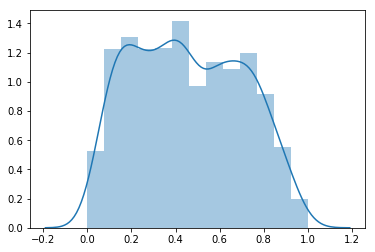

In [4]:
gene_id = 'PA1673'
PA1673_only = pd.DataFrame(data[gene_id], index=data.index, columns=[gene_id])
sns.distplot(PA1673_only)

## 2. Are the genes changing linearly with respect to PA1673?

In [5]:
# Sort samples by PA1673 expression (lowest --> highest)
data_sorted = data.sort_values(by=[gene_id])
data_sorted.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
Glu_6Hour_(Pae_G1a).CEL,0.208763,0.206948,0.489384,0.268002,0.443039,0.655531,0.253524,0.450379,0.423884,0.647729,...,0.361040,0.464446,0.291078,0.533564,0.368903,0.873974,0.573474,0.372519,0.223440,0.198277
JS-A84.9.07.CEL,0.573841,0.393800,0.433020,0.323490,0.587715,0.522578,0.336587,0.715134,0.391078,0.245615,...,0.413921,0.430351,0.400824,0.407876,0.650810,0.840608,0.494076,0.391068,0.253154,0.035655
GSM774141_B12-0_3.CEL,0.888877,0.794609,0.675173,0.810603,0.676368,0.476494,0.144484,0.907763,0.968479,0.196780,...,0.651603,0.719922,0.808752,0.915146,0.869980,0.255556,0.783530,0.878509,0.880646,0.825883
GSM774136_B6-4_1.CEL,0.846536,0.764321,0.674080,0.924636,0.708149,0.427118,0.134049,0.870328,0.881907,0.244134,...,0.720432,0.709724,0.733110,0.832469,0.925607,0.235217,0.835157,0.838456,0.819095,0.743265
120330-10978D_M4_(Pae_G1a).CEL,0.656005,0.789647,0.390163,0.641505,0.429094,0.441882,0.323045,0.494680,0.626833,0.282136,...,0.244071,0.563862,0.575157,0.758608,0.663031,0.144855,0.291325,0.513102,0.753419,0.674350


In [6]:
# For each gene plot gene expression trend along PA1673 gradient
# Use pearson correlation score to compare PA1673 profile with all other genes
# Pearson correlation evaluates the linear relationship between two continuous variables
data_corr = data_sorted.corr(method='pearson')
data_corr.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
Gene_symbol,,,,,,,,,,,,,,,,,,,,,
PA0001,1.000000,0.779675,0.733440,0.712741,0.618276,0.271469,-0.439087,0.630136,0.710458,-0.127694,...,0.333006,0.546864,0.745421,0.655231,0.654152,-0.572969,0.240731,0.560906,0.705783,0.661062
PA0002,0.779675,1.000000,0.568071,0.771462,0.450058,0.116412,-0.306666,0.545046,0.595216,-0.277806,...,0.073948,0.561558,0.700187,0.525938,0.543937,-0.574464,0.184688,0.503258,0.696306,0.523187
PA0003,0.733440,0.568071,1.000000,0.631487,0.623500,0.420747,-0.537806,0.561856,0.677663,0.026342,...,0.440695,0.453793,0.689178,0.687790,0.528471,-0.390966,0.302221,0.557760,0.624907,0.524225
PA0004,0.712741,0.771462,0.631487,1.000000,0.473680,0.224600,-0.410620,0.597444,0.678351,-0.153381,...,0.215746,0.533391,0.580613,0.577376,0.483933,-0.452918,0.263605,0.621980,0.636987,0.496236
PA0005,0.618276,0.450058,0.623500,0.473680,1.000000,0.389522,-0.492096,0.540635,0.610654,-0.024608,...,0.418210,0.518228,0.587593,0.626309,0.559322,-0.336953,0.336387,0.585320,0.582077,0.493543


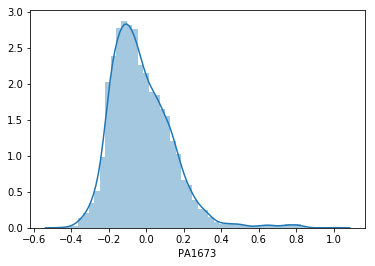

In [7]:
# Plot distribution of correlation scores
data_corr_PA1673 = data_corr[gene_id]
sns.distplot(data_corr_PA1673)

## 3.  Plot the expression of genes along the PA1673 gradient
Are the genes changing linearly with respect to PA1673?

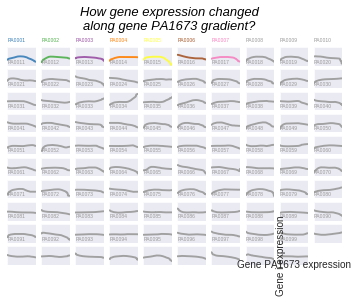

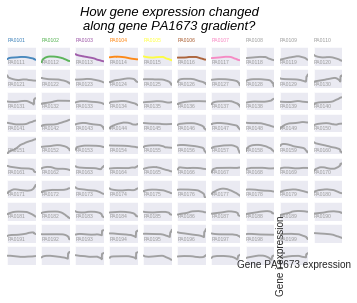

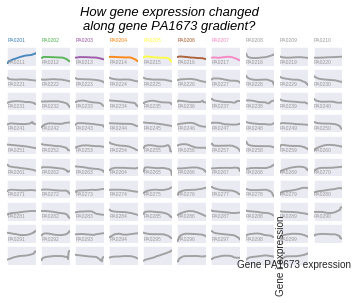

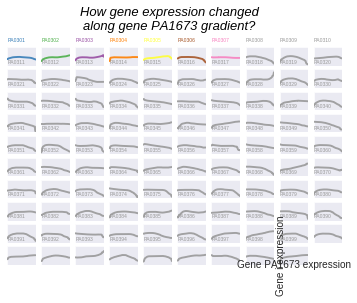

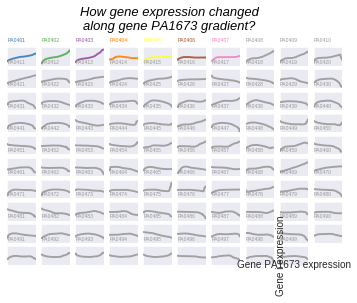

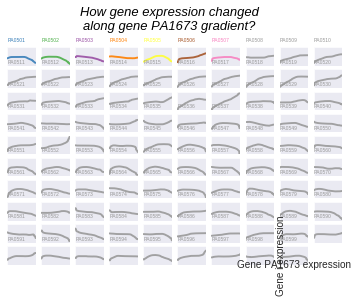

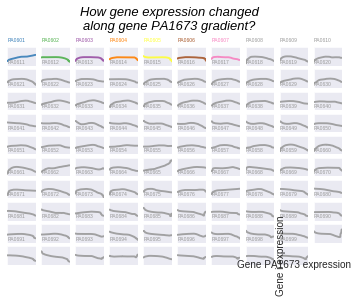

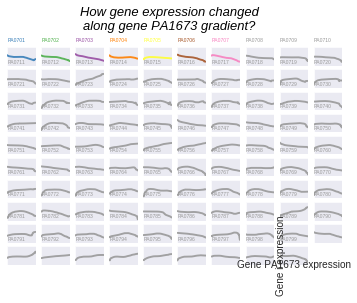

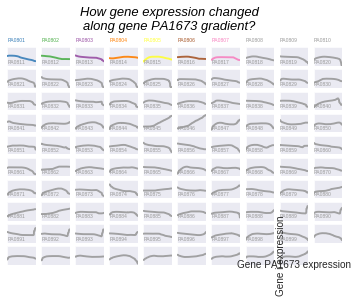

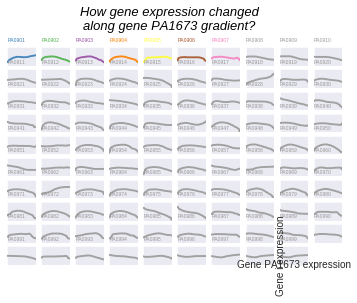

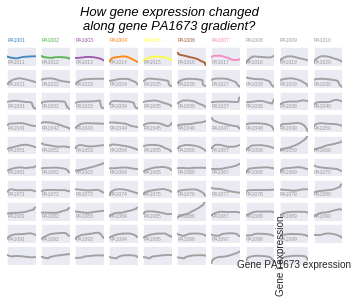

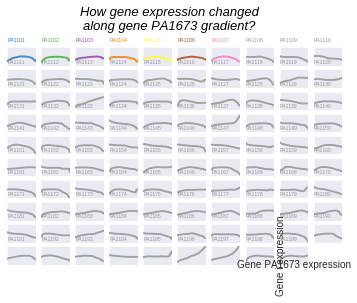

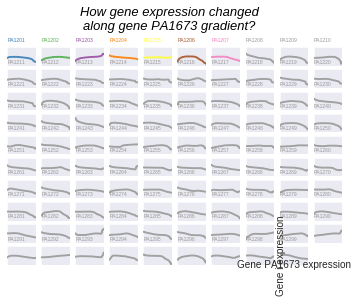

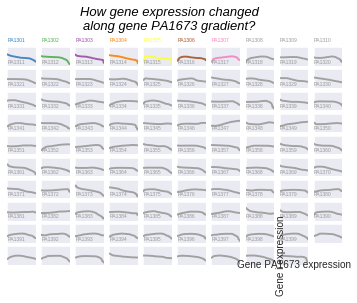

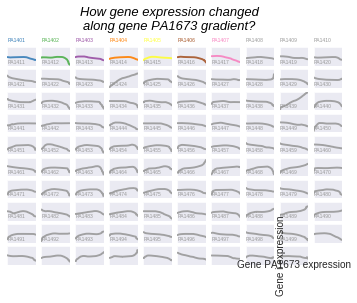

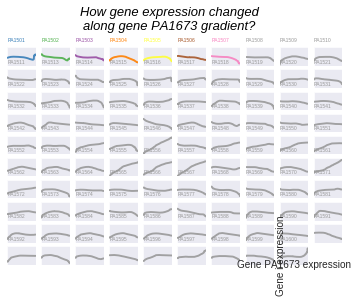

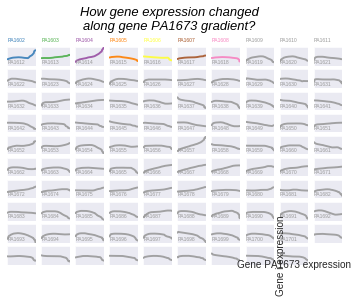

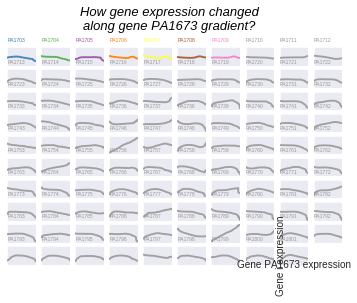

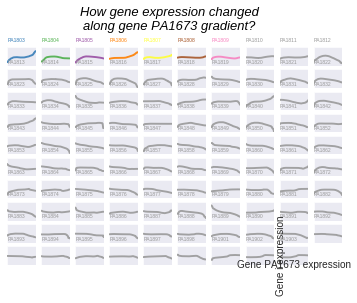

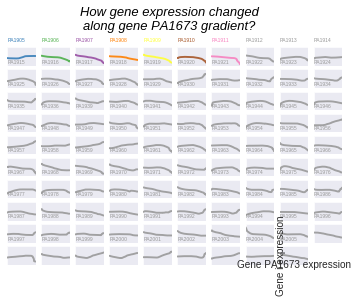

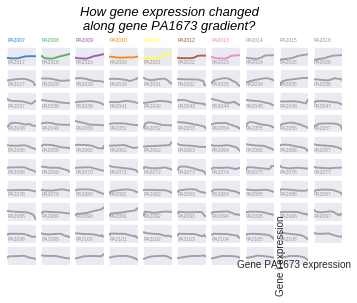

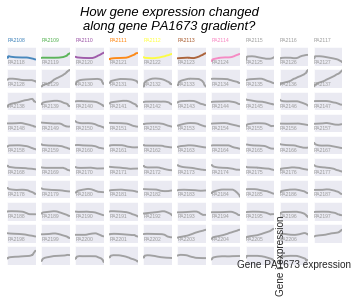

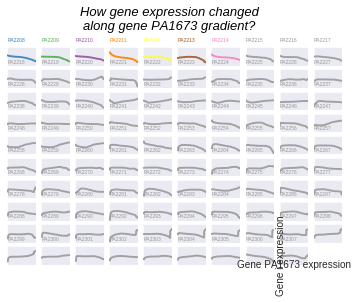

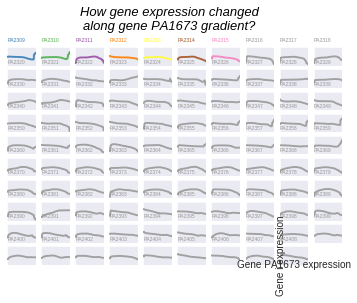

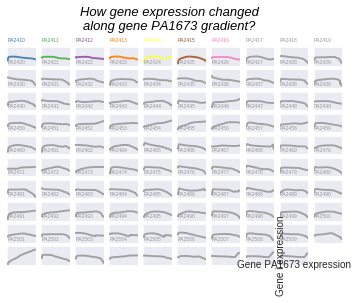

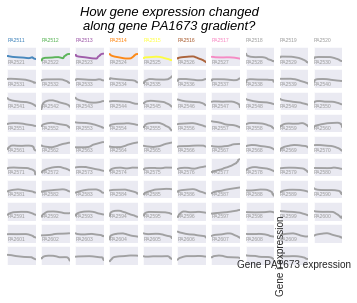

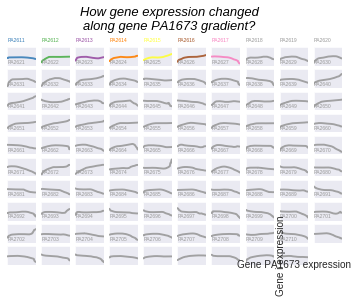

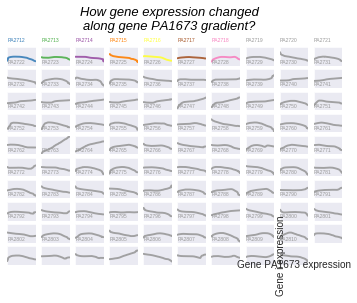

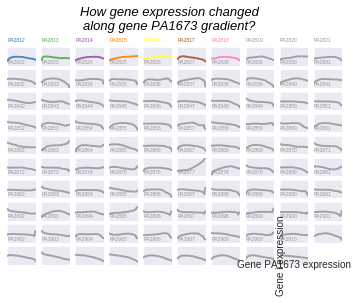

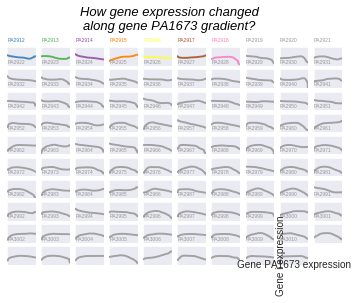

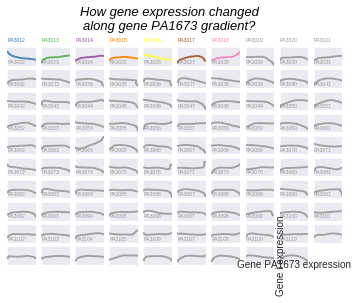

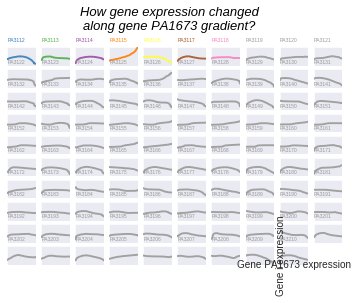

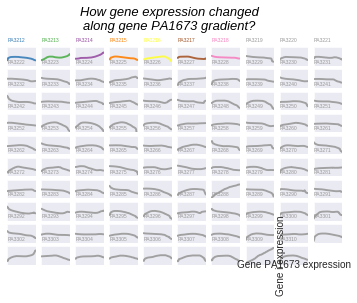

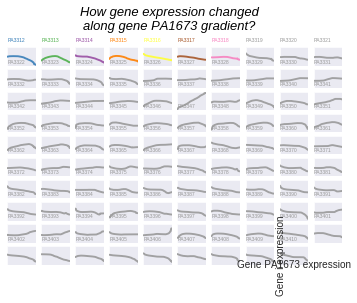

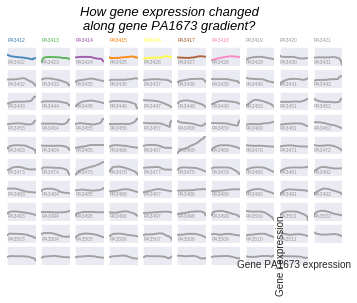

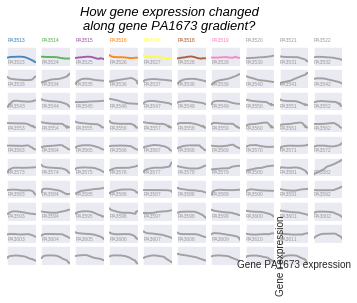

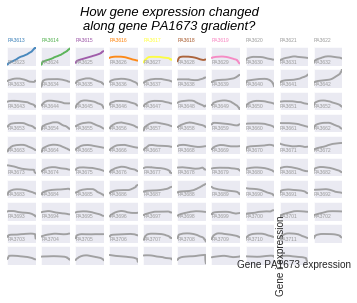

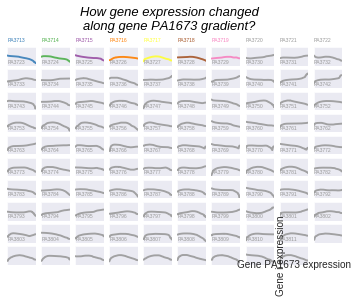

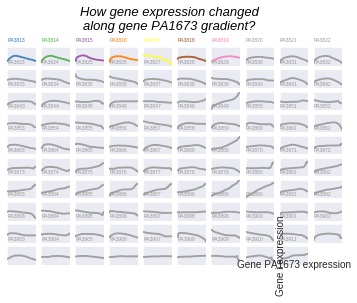

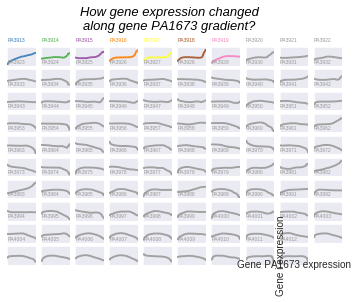

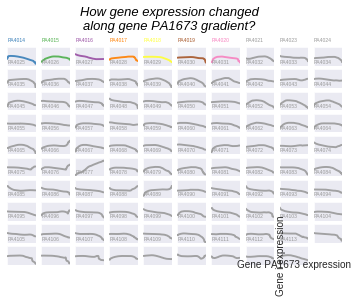

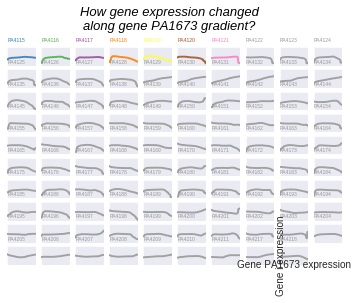

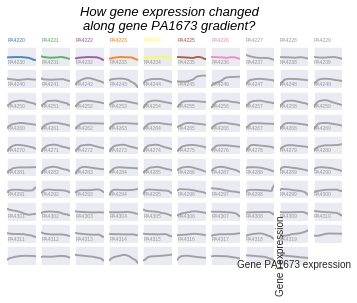

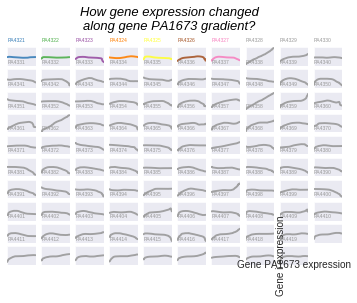

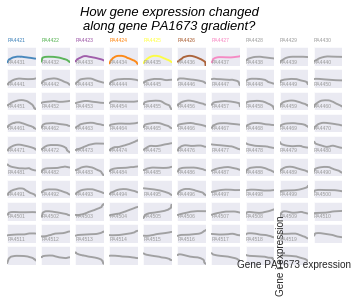

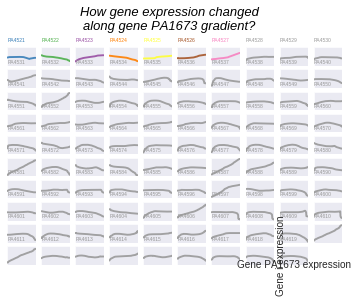

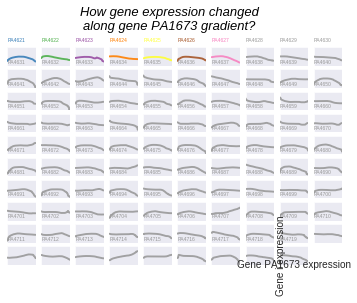

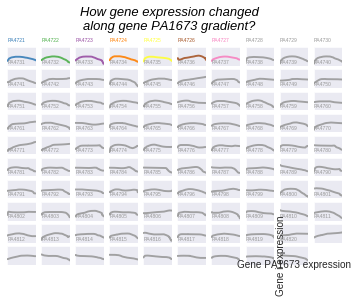

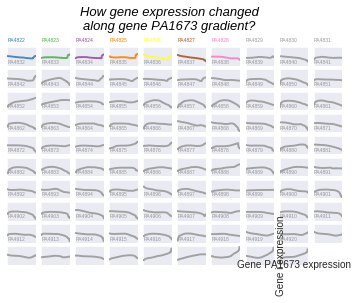

CPU times: user 17min 6s, sys: 2.33 s, total: 17min 8s
Wall time: 17min 8s


In [8]:
%%time
# Sort samples by PA1673 expression (lowest --> highest)
data_sorted = data.sort_values(by=[gene_id])
data_sorted.head()

# For each gene plot gene expression trend along PA1673 gradient

# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num_genes = data_sorted.shape[1]
num_panels = 100

# Output file directory
base_dir = os.path.join(os.path.dirname(os.getcwd()), "exploration_results", "real_data")
os.makedirs(base_dir, exist_ok=True)
    
for panel in range(mt.ceil(num_genes%num_panels)):
    rows = mt.sqrt(num_panels)
    cols = rows
    num=0
    
    data_subsample = data_sorted.drop(gene_id, axis=1).iloc[: , (panel*num_panels):((panel+1)*num_panels)-1]
    
    for column in data_subsample:
        num+=1

        # Find the right spot on the plot
        plt.subplot(rows,cols, num)

        # Plot the lineplot --Add smoothing to see trend
        y_smooth = lowess(data_sorted[gene_id], data_subsample[column])[:,1]
        plt.plot(data_sorted[gene_id], y_smooth, marker='', color=palette(num), linewidth=1.9, alpha=0.9, label=column)
               
        # Same limits for everybody!
        plt.xlim(0,1)
        plt.ylim(0,1)

        plt.tick_params(labelbottom='off')
        plt.tick_params(labelleft='off')
        # Not ticks everywhere
        #if num in range(7) :
        #    plt.tick_params(labelbottom='off')
        #if num not in [1,4,7] :
        #    plt.tick_params(labelleft='off')

        # Add title
        plt.title(column, loc='left', fontsize=5, fontweight=0, color=palette(num) )

    # general title
    plt.suptitle("How gene expression changed\nalong gene {} gradient?".format(gene_id), fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

    # Axis title
    plt.text(0.5, 0.02, 'Gene {} expression'.format(gene_id), ha='center', va='center')
    plt.text(0.06, 0.5, 'Gene i expression', ha='center', va='center', rotation='vertical')
    
    # Save each panel as a figure
    file_out = PdfPages(os.path.join(base_dir, 'Panel_{}.pdf'.format(panel)))
    plt.savefig(file_out, format='pdf', bbox_inches = 'tight')
    plt.show()
    file_out.close()
